<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Gradient_Descent_for_Linear_and_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
###
# Import packages
###

import numpy as np
import matplotlib.pyplot as plt
import time

Text(0.5, 1.0, 'The Data')

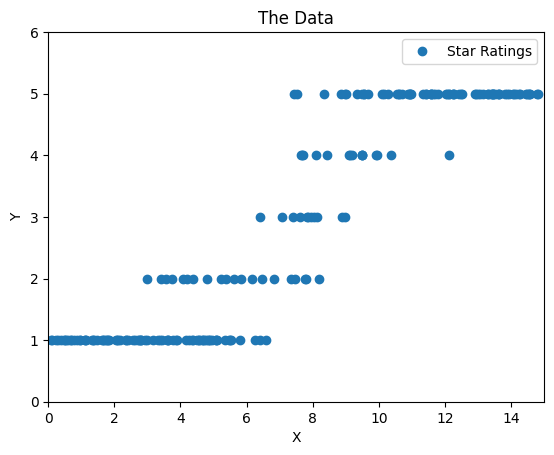

In [2]:
###
# Create the data
###

def simple_plot(X,Y,my_label='',my_style='o'):
  plt.plot(X,Y,my_style,label=my_label)
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend()


def sort_plot(X,Y,my_label='',my_style='-'):
  #like simple plot but it first sorts the X,Y by X value
  Sort_X,Sort_Y = zip(*sorted(zip(X, Y)))
  simple_plot(Sort_X,Sort_Y,my_label,my_style)

def generate_data(N,y_max=5,y_min=1):
  x_max = 15
  X = x_max*np.random.rand(N)
  p = np.exp(X-x_max/2)/(1+np.exp(X-x_max/2))

  Y = np.random.binomial(y_max-y_min, p, N) + y_min
  return X,Y

N = 200

np.random.seed(42)

X,Y = generate_data(N)
simple_plot(X,Y,'Star Ratings')
plt.axis([0,15,0,6])
plt.title('The Data')

## Setting up train/test split

Text(0.5, 1.0, 'Train and Test Set Split')

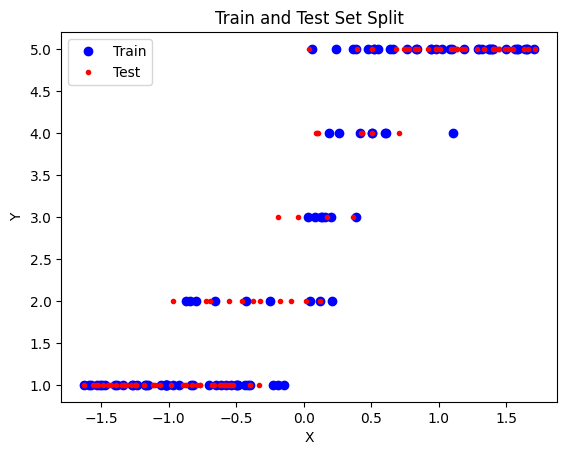

In [3]:
###
#Create a training set and test set for cross validation
###
def test_train_split(X_features,Y,train_N=None):
  N = len(Y)

  if train_N == None:
    train_N = int(0.5*len(Y)) #Size of the test set

  perm = np.random.permutation(N) #permutation used to shuffle the train/test set
  shuffled_X = X_features[perm]
  shuffled_Y = Y[perm]
  X_train,Y_train = shuffled_X[0:train_N], shuffled_Y[0:train_N]
  X_test,Y_test = shuffled_X[train_N:N], shuffled_Y[train_N:N]

  return X_train,Y_train,X_test,Y_test


#Useful for adding new features!
def standardize(x):
  return (x - np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

X_features = np.stack( [np.ones_like(X),standardize(X)] ,axis=-1) #Create features from the given X value
# In this case, we add a column of 1's to include an intercept in our model
X_train,Y_train,X_test,Y_test = test_train_split(X_features,Y)


simple_plot(X_train[:,1],Y_train,'Train','ob')
simple_plot(X_test[:,1],Y_test,'Test','.r')
plt.title("Train and Test Set Split")

# Linear Regeression

Uses the model $$f(x) = \sum_{j=1}^m \beta_i x_i $$ where $m$ is the number of features $x = (x_1,\ldots,x_m)$, $m=\text{dim}(m)$, and the loss function $$L
(\beta) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2} (y_i - f(x_i;\beta))^2$$, where $(x_i,y_i)_{i=1}^n$ are the training examples, $n = \text{number of examples}$. The update rule uses the gradient:
$$ \partial_{\beta_j} L(\beta) = \frac{1}{n} \sum_{i=1}^n \Big(y_i - f(x_i;\beta)\Big) x_{ij} $$   

Text(0.5, 1.0, 'Plot of f when beta = [-0.00163597 -0.42603234]')

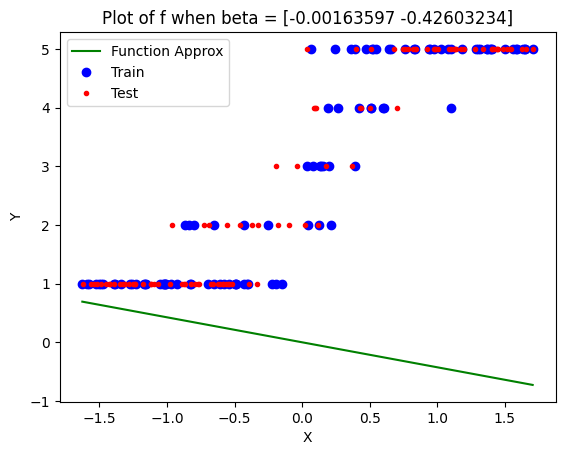

In [4]:
###
# Setup the linear regression function and its gradient
###

def f(x,beta):
  #Input: x is an (n,m) array, beta is a (m,) arrray
  #Output: an (n,) array with the value of f

  #Note: x*beta is shape (n,m) by the array broadcasting rules
  #so summing over the last axis gives us what we want!
  return np.sum(x*beta,axis=-1)


#Here is what the graph of f looks like
beta = np.random.randn( X_train.shape[-1] )
preds = f(X_train,beta)
sort_plot(X_train[:,1], preds ,my_label = 'Function Approx',my_style = '-g')
simple_plot(X_train[:,1],Y_train,'Train','ob')
simple_plot(X_test[:,1],Y_test,'Test','.r')
plt.title(f"Plot of f when beta = {beta}")

## Gradient Function and gradient descent

Calcualte the gradient according to the equation, and then update the weights according to the gradient descent update rule

$$\beta_j = \beta_j - \alpha_{LR} \cdot \partial_{\beta_j} L(\beta)$$,

where $\alpha_{LR}$ represents the learning rate for each iteration.

In [5]:
###
# Calculate the gradient
###
def MSE_loss(x,y,beta):
  #Input: x is an (n,m) array, y is an (n,) array, and beta is a (m,) arrray
  #Output: A scalar which contains the MSE

  #difference between y and the prediction f(x,beta)
  pred_error = f(x,beta)-y #shape (n,) with the difference between y and f

  return np.mean( pred_error**2 )

def MSE_grad_loss(x,y,beta):
  #Input: x is an (n,m) array, y is an (n,) array, and beta is a (m,) arrray
  #Output: an (m,) array with the value d_(beta_j)Loss(beta)
  #See the equation at top of section!

  #difference between y and the prediction f(x,beta)
  pred_error = f(x,beta)-y #shape (n,) with the difference between y and f

  #make pred_error shape (n,1) so it can broadcase with x, then multiply and sum
  return np.mean( np.expand_dims(pred_error,axis=1)*x, axis=0 )

my_grad = MSE_grad_loss(X_train,Y_train,beta)
print("Shape of gradient: ", my_grad.shape)

Shape of gradient:  (2,)


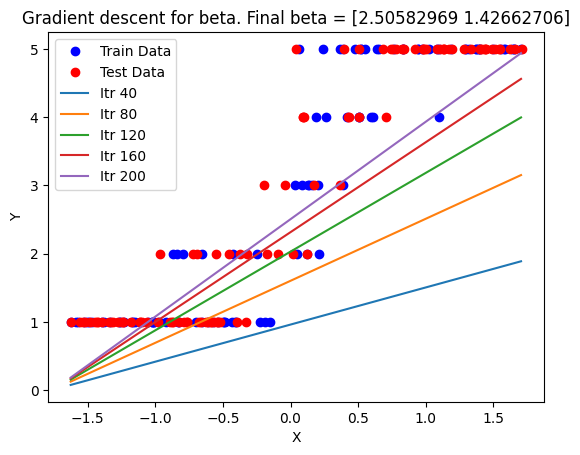

Text(0.5, 1.0, 'MSE Loss throughout training')

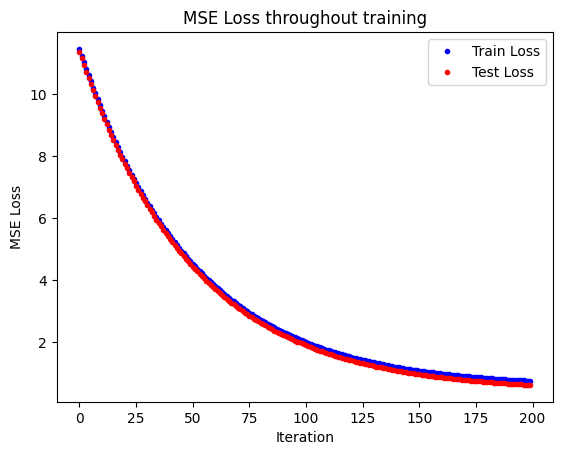

In [6]:
###
# Run gradient descent for the linear model
###

learning_rate = 0.01
num_iterations = 200
num_displays = 5
train_loss_history = np.zeros(num_iterations)
test_loss_history = np.zeros(num_iterations)

#Gradient descent algorithm!

###TRAINING
beta = np.zeros( X_train.shape[-1] )
simple_plot(X_train[:,1],Y_train,'Train Data','ob')
simple_plot(X_test[:,1],Y_test,'Test Data','or')
for i in range(num_iterations):
  beta -= learning_rate*MSE_grad_loss(X_train,Y_train,beta) #Gradient descent!
  train_loss_history[i] = MSE_loss(X_train,Y_train,beta)
  test_loss_history[i] = MSE_loss(X_test,Y_test,beta)
  if (i+1)% (num_iterations/num_displays) == 0: #plot what happens num_displays times
    sort_plot(X_train[:,1],f(X_train,beta),f'Itr {i+1}','-')
plt.title(f"Gradient descent for beta. Final beta = {beta}")
plt.show()

###LOSS HISTORY
x_axis = np.arange(0,num_iterations)
plt.plot(x_axis, train_loss_history, '.b', label='Train Loss')
plt.plot(x_axis, test_loss_history, '.r',label='Test Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("MSE Loss throughout training")




# Logisitic Regression

Uses the model $$p(x) = \sigma\left( \sum_{j=1}^m \beta_i x_i \right)$$ where $m$ is the number of features $x = (x_1,\ldots,x_m)$, $m=\text{dim}(m)$, and $\sigma$ is the sigmoid function

$$ \sigma (x) = \frac{e^x}{1+e^x}$$

and the cross-entropy loss function $$L(\beta) = \frac{1}{n} \sum_{i=1}^n y_i \log(p(x_i)) + (1-y_i) \log(1-p(x_i))$$, where $(x_i,y_i)_{i=1}^n$ are the training examples, $n = \text{number of examples}$. The update rule uses the gradient which remarkably simplifies to:
$$ \partial_{\beta_j} L(\beta) = \frac{1}{n} \sum_{i=1}^n \Big(y_i - p(x_i;\beta)\Big) x_{ij} $$   

Text(0.5, 1.0, 'Train and Test Set Split')

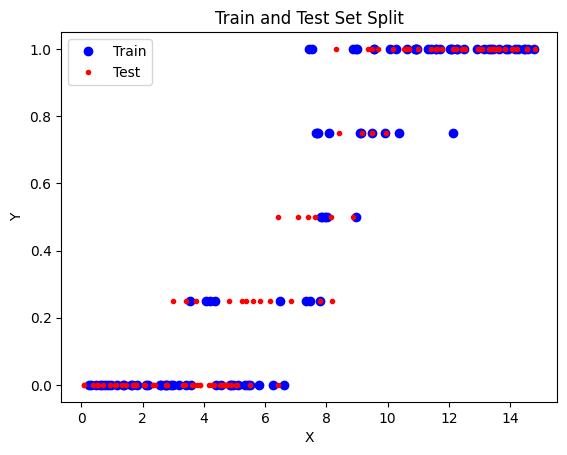

In [7]:
###
# Setup the data
###

#For logisitic regression, the y values must be in the interval (0,1)!

X_features = np.stack( [np.ones_like(X), X ] ,axis=-1) #Create features from the given X value
# In this case, we add a column of 1's to include an intercept in our model
Y_zero_one_valued = (Y-1)/4

X_train,Y_train,X_test,Y_test = test_train_split(X_features,Y_zero_one_valued)


simple_plot(X_train[:,1],Y_train,'Train','ob')
simple_plot(X_test[:,1],Y_test,'Test','.r')
plt.title("Train and Test Set Split")

Text(0.5, 1.0, 'Plot of f when beta = [ 0.2597225  -0.90431663]')

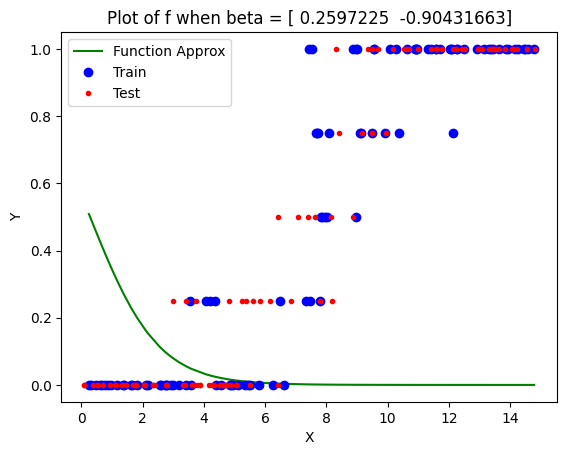

In [8]:
###
# Setup the estiamtion function
###

def sigmoid(x):
  my_exp = np.exp(x)
  return my_exp/(1+my_exp)

def p(x,beta):
  #reuse the f function from the linear regression
  return sigmoid(f(x,beta))


#Here is what the graph of f looks like
beta = np.random.randn( X_train.shape[-1] )
sort_plot(X_train[:,1],p(X_train,beta),'Function Approx','-g')
simple_plot(X_train[:,1],Y_train,'Train','ob')
simple_plot(X_test[:,1],Y_test,'Test','.r')
plt.title(f"Plot of f when beta = {beta}")

In [9]:
###
# Calculate the gradient
###
def Cross_Entropy_loss(x,y,beta):
  #Input: x is an (n,m) array, y is an (n,) array, and beta is a (m,) arrray
  #Output: A scalar which contains the Cross_Entropy_loss

  return -np.mean( y*np.log( p(x,beta) )+(1-y)*np.log( 1-p(x,beta) ) ) #shape (n,) with the difference between y and f

def Logistic_grad_loss(x,y,beta):
  #Input: x is an (n,m) array, y is an (n,) array, and beta is a (m,) arrray
  #Output: an (m,) array with the value d_(beta_j)Loss(beta)
  #See the equation at top of section!

  #difference between y and the prediction f(x,beta)
  pred_error = p(x,beta)-y #shape (n,) with the difference between y and f

  #make pred_error shape (n,1) so it can broadcase with x, then multiply and sum
  return np.mean( np.expand_dims(pred_error,axis=1)*x, axis=0 )

my_grad = Logistic_grad_loss(X_train,Y_train,beta)
print("Shape of gradient: ", my_grad.shape)

Shape of gradient:  (2,)


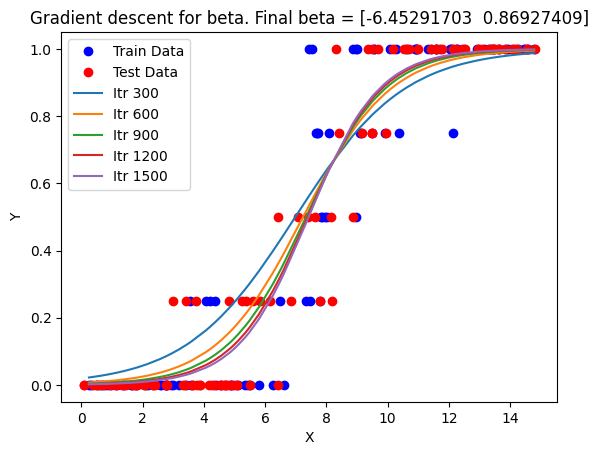

Text(0.5, 1.0, 'CE Loss throughout training')

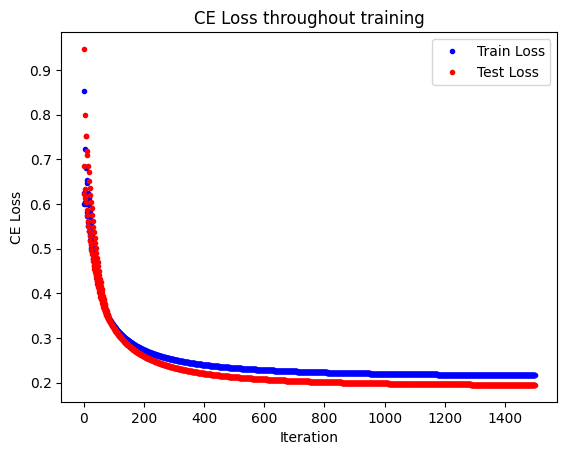

In [10]:
###
# Run gradient descent for the linear model
###

learning_rate = 0.2
num_iterations = 1500
num_displays = 5
train_loss_history = np.zeros(num_iterations)
test_loss_history = np.zeros(num_iterations)

#Gradient descent algorithm!

###TRAINING
beta = np.zeros( X_train.shape[-1] )
simple_plot(X_train[:,1],Y_train,'Train Data','ob')
simple_plot(X_test[:,1],Y_test,'Test Data','or')
for i in range(num_iterations):
  beta -= learning_rate*Logistic_grad_loss(X_train,Y_train,beta) #Gradient descent!
  train_loss_history[i] = Cross_Entropy_loss(X_train,Y_train,beta)
  test_loss_history[i] = Cross_Entropy_loss(X_test,Y_test,beta)
  if (i+1)% (num_iterations/num_displays) == 0: #plot what happens num_displays times
    sort_plot(X_train[:,1],p(X_train,beta),f'Itr {i+1}','-')
plt.title(f"Gradient descent for beta. Final beta = {beta}")
plt.show()

###LOSS HISTORY
x_axis = np.arange(0,num_iterations)
plt.plot(x_axis, train_loss_history, '.b', label='Train Loss')
plt.plot(x_axis, test_loss_history, '.r',label='Test Loss')
plt.xlabel("Iteration")
plt.ylabel("CE Loss")
plt.legend()
plt.title("CE Loss throughout training")

